In [21]:
%load_ext autoreload
%autoreload 2

In [22]:
import pandas as pd

ds, ds_test = pd.read_csv('../data/train.csv'), pd.read_csv('../data/test.csv')
ds

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


holiday       0.005393
workingday    0.011594
windspeed     0.101369
weather       0.128655
season        0.163439
humidity      0.317371
atemp         0.389784
temp          0.394454
casual        0.690414
registered    0.970948
count         1.000000
Name: count, dtype: float64


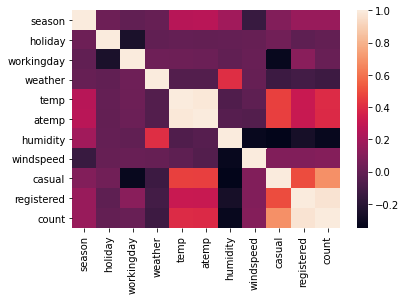

In [23]:
import seaborn as sns
from core import *

sns.heatmap(ds.corr())
print(corr(ds))

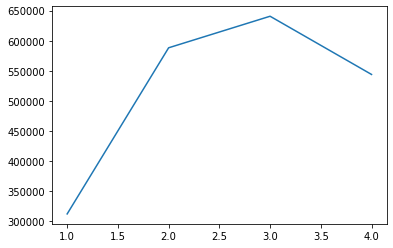

In [24]:
import matplotlib.pyplot as plt

plt.plot(ds.groupby('season').sum()['count'])

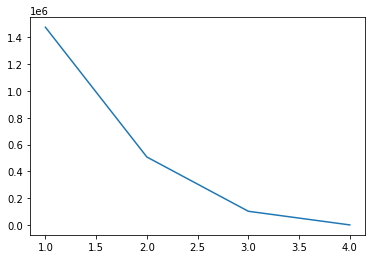

In [25]:
plt.plot(ds.groupby('weather').sum()['count'])

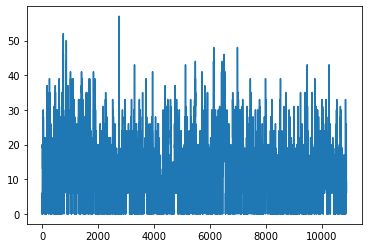

In [26]:
plt.plot(ds.windspeed)

In [27]:
ds.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [28]:
ds.astype('object').describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886,10886,10886,10886,10886.00,10886.00,10886,10886.0,10886,10886,10886
unique,10886,4,2,2,4,49.00,60.00,89,28.0,309,731,822
top,2011-04-12 21:00:00,4,0,1,1,14.76,31.06,88,0.0,0,3,5
freq,1,2734,10575,7412,7192,467.00,671.00,368,1313.0,986,195,169


In [29]:
import datetime

tm = ds.datetime.iloc[3]
dt = datetime.datetime.strptime(tm, '%Y-%m-%d %H:%M:%S')
print(tm, dt, dt.hour)

2011-01-01 03:00:00 2011-01-01 03:00:00 3


In [30]:
def prep_baseline_ds(ds_raw):
    ds = ds_raw.copy()
    ds['hour'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour)
    ds['month'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month)
    to_drop = ['datetime']
    for col in ['registered', 'casual']:
        if col in ds: to_drop.append(col)
    ds.drop(to_drop, axis=1, inplace=True)
    return ds

prep_baseline_ds(ds).to_csv('../data/feed/feed_baseline.csv', index=False)

In [31]:
prep_baseline_ds(ds_test).to_csv('../data/feed/feed_baseline_test.csv', index=False)

In [32]:
from core import *
from sklearn.tree import DecisionTreeRegressor

def last_humidity(hum, period):
    res = [hum[0]]
    arr = np.array(hum)
    for i in range(1, len(hum)):
        res.append(np.sum(arr[max(0, i - period):i]))
    return res

def prep_ds(ds_raw, is_test=False):
    ds = ds_raw.copy()

    if not is_test:
        ds = handle_outliers(ds, ['count', 'atemp', 'temp',
                                  'humidity', 'windspeed'], drop=True)

    ds['hour'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour)
    ds['month'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month)
    ds['day_of_week'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').weekday())

    ds = groupby_mean(ds, [
        ('month', 'temp'),
        ('month', 'atemp')
    ])

    to_drop = ['datetime']
    for col in ['registered', 'casual']:
        if col in ds: to_drop.append(col)
    ds.drop(to_drop, axis=1, inplace=True)

    return ds

process_ds = prep_ds(ds)
process_ds.to_csv('../data/feed/feed_2[outliers,day of week,groupby].csv', index=False)
prep_ds(ds_test, is_test=True).to_csv('../data/feed/feed_2[outliers,day of week,groupby]_test.csv', index=False)
process_ds

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month,day_of_week,temp_month_mean,atemp_month_mean
0,1,0,0,1,15.58,19.695,76,16.9979,36,10,1,5,14.311121,17.185388
1,1,0,0,1,14.76,16.665,81,19.0012,56,11,1,5,14.311121,17.185388
2,1,0,0,1,17.22,21.210,77,19.0012,84,12,1,5,14.311121,17.185388
3,1,0,0,2,18.86,22.725,72,19.9995,94,13,1,5,14.311121,17.185388
4,1,0,0,2,18.86,22.725,72,19.0012,106,14,1,5,14.311121,17.185388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,4,0,1,1,17.22,21.210,50,23.9994,334,16,12,2,14.672379,17.788810
5448,4,0,1,1,14.76,17.425,57,15.0013,241,20,12,2,14.672379,17.788810
5449,4,0,1,1,13.94,15.910,61,15.0013,168,21,12,2,14.672379,17.788810
5450,4,0,1,1,13.94,17.425,61,6.0032,129,22,12,2,14.672379,17.788810


In [33]:
eval_data(DecisionTreeRegressor(),
          ds=process_ds,
          rounds=150)

0.5811186434741732


In [34]:
from core import *

def prep_ds2(ds_raw):
    ds = ds_raw.copy()
    ds['hour'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour)
    ds['month'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month)
    ds['day_of_week'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').weekday())
    ds['year'] = ds['datetime'].apply(lambda dt: datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year)

    ds = drop(ds, ['datetime', 'registered', 'casual'])
    ds = transform(ds, ['count'])

    return ds

prep_ds2(ds).to_csv('../data/feed/feed_3[log].csv', index=False)
prep_ds2(ds_test).to_csv('../data/feed/feed_3[log]_test.csv', index=False)
prep_ds2(ds)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,month
0,1,0,0,1,9.84,14.395,81,0.0000,2.833213,0,1
1,1,0,0,1,9.02,13.635,80,0.0000,3.713572,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,3.496508,2,1
3,1,0,0,1,9.84,14.395,75,0.0000,2.639057,3,1
4,1,0,0,1,9.84,14.395,75,0.0000,0.693147,4,1
...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,5.820083,19,12
10882,4,0,1,1,14.76,17.425,57,15.0013,5.488938,20,12
10883,4,0,1,1,13.94,15.910,61,15.0013,5.129899,21,12
10884,4,0,1,1,13.94,17.425,61,6.0032,4.867534,22,12
